Step 3 notebooks are revolved around using the latent space.

Steps performed in this notebook:

**1. Load in CCA dataframes:** Created by notebook 2-perform_cca.

**2. Nearest Neighbour Search 1 random test case:** Here, 1 random spectra is queried in the structure space of the joint embedding. This is done in order to show some examples in the thesis and presentation of how the nearest neighbour search is done.

In [ ]:
# Set plot style
import matplotlib.pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

import matplotlib.style as style
style.use('ggplot')
%matplotlib inline

## 1. Load in CCA dataframes

In [166]:
import os
import pickle

# Load the CCA latent spaces for Spec2Vec and MS2DeepScore

def load_pickle(fn, path):
    with open(os.path.join(path, '%s.pickle' % fn), 'rb') as f:
        df = pickle.load(f) 
    return df

latent_dims = 100

df_spec2vec_cca = load_pickle('dataframe_spec2vec_cca_%d' % (latent_dims), '/lustre/BIF/nobackup/unen004/data')
df_spec2vec_dcca = load_pickle('dataframe_spec2vec_dcca_%d' % (latent_dims), '/lustre/BIF/nobackup/unen004/data')

df_ms2ds_cca = load_pickle('dataframe_ms2ds_cca_%d' % (latent_dims), '/lustre/BIF/nobackup/unen004/data')
df_ms2ds_dcca = load_pickle('dataframe_ms2ds_dcca_%d' % (latent_dims), '/lustre/BIF/nobackup/unen004/data')

In [167]:
dataset = "ALL_GNPS_210409_positive"

# Load in tanimoto similarity matrix for comparisons later
tanimoto_fn = os.path.join("/mnt/LTR_userdata/hooft001/mass_spectral_embeddings", "datasets", dataset, "%s_tanimoto_scores.pickle" % dataset)
with open(tanimoto_fn, "rb") as f:
    tanimoto_matrix = pickle.load(f)

## Nearest Neigbour Search 1 random test case.
First a random spectra is taken from either the test or train set, and then a number of narest neighbours (e.g. 10) are queried based on the lowest cosine distance. Then the tanimoto similarity is calculated between the structure belonging to the query and the nearest neighbours. Also, the structures are printed in order to visualise what they are.

In [168]:
metric = 'cosine'
nn = 10

In [169]:
from scipy.spatial import distance
import pandas as pd

def get_n_nearest_neighbours(query_spectrum_id, df, metric='cosine', x='X', y='Y', nn=10):
    #df_query = df[df['spectrum_id'] == query_spectrum_id]
    df_query = df.loc[[query_spectrum_id]]
    df_library = df[df['set'] == 'train']
    
    # Make distance matrix between X and Y
    cdist_matrix = distance.cdist([x for x in df_query[x]],
                                  [x for x in df_library[y]],
                                  metric=metric)
    
    dist_list = cdist_matrix[0]

    q_inchi = df_query.inchikey14.values[0]  # Get first 14 chars of inchikey of query

    # Turn distances into dataframe
    dist_df = pd.DataFrame(dist_list, columns=['dist'], index=df_library.index)

    dist_df = pd.concat([df_library, dist_df], axis=1)

    # Sort on distance from small to high
    dist_df.sort_values(by='dist', inplace=True)

    # Take top n nearest neighbours, and keep only the inchikeys
    return dist_df[:nn]

In [176]:
# take a random spectra, either from test or train
query = df_spec2vec_cca.loc[df_spec2vec_cca['set'] == 'test'].sample()
spectrum_id = query.index[0]
query

,compound_name,smiles,inchikey,inchikey14,cf_kingdom,cf_superclass,cf_class,cf_subclass,cf_direct_parent,npc_class_results,...,npc_pathway_results,npc_isglycoside,mol,sentence,ms2ds,spec2vec,mol2vec,set,X,Y
spectrum_id,,,,,,,,,,,,,,,,,,,,,
CCMSLIB00000845044,"7-chloro-4,8-dihydroxy-6-methoxy-3-methyl-3,4-...",COC1=C(Cl)C(O)=C2C(=O)OC(C)C(O)C2=C1,UPALKCDWIDYZDP-UHFFFAOYSA-N,UPALKCDWIDYZDP,Organic compounds,Organoheterocyclic compounds,Benzopyrans,2-benzopyrans,2-benzopyrans,Isocoumarins,...,Shikimates and Phenylpropanoids,0,"<img data-content=""rdkit/molecule"" src=""data:i...","(2246728737, 3975275337, 864674487, 2076190208...","[0.0, 0.15894325810181506, 0.0, 0.020005448953...","[0.07259720877854732, 0.0598621228326547, 0.04...","[0.026432657421691364, -0.03544546154798468, -...",test,"[2.3543895033442492, 0.30457536966440246, -0.6...","[1.1247590482526673, 1.2639685831381557, -0.14..."


In [171]:
nn_spec2vec = get_n_nearest_neighbours(spectrum_id, df_spec2vec_cca, nn=nn, x='spec2vec', y='spec2vec')
nn_ms2ds = get_n_nearest_neighbours(spectrum_id, df_ms2ds_cca, nn=nn, x='ms2ds', y='ms2ds')

nn_spec2vec_cca = get_n_nearest_neighbours(spectrum_id, df_spec2vec_cca, nn=nn)
nn_ms2ds_cca = get_n_nearest_neighbours(spectrum_id, df_ms2ds_cca, nn=nn)

nn_spec2vec_dcca = get_n_nearest_neighbours(spectrum_id, df_spec2vec_dcca, nn=nn)
nn_ms2ds_dcca = get_n_nearest_neighbours(spectrum_id, df_ms2ds_dcca, nn=nn)

In [172]:
from rdkit.Chem import Draw
def draw_mols(df):
    a = Draw.MolsToGridImage(df['mol'].values,molsPerRow=5,subImgSize=(200,200),legends=[x for x in df.index.values],
                            returnPNG=True)    
    return a

def draw_mol(df):
    a = Draw.MolsToGridImage(df['mol'].values,molsPerRow=1,subImgSize=(200,200),returnPNG=True)    
    return a
    
def return_mol(df):
    return df['mol'].values[0]

In [173]:
print("compound_name\t\tdist\ttani")
def assess_n_nearest_neighbours(df_query, df_result):
    q_inchi = (df_query['inchikey14'].values[0])
    spec_list = []
    for i, res in df_result.iterrows():
        r_inchi = res['inchikey14']
        print("%s\t%.3f\t%.3f" % (i, res['dist'], tanimoto_matrix[q_inchi][r_inchi]))
        spec_list.append(i)
    print(spec_list)
    print("")
    
    
#assess_n_nearest_neighbours(query, nn_spec2vec)
assess_n_nearest_neighbours(query, nn_spec2vec_cca)
#assess_n_nearest_neighbours(query, nn_spec2vec_dcca)
    
print("\n")

#assess_n_nearest_neighbours(query, nn_ms2ds)
#assess_n_nearest_neighbours(query, nn_ms2ds_cca)
#assess_n_nearest_neighbours(query, nn_ms2ds_dcca)


compound_name		dist	tani
CCMSLIB00000577732	0.389	0.483
CCMSLIB00000577830	0.398	0.454
CCMSLIB00000854763	0.425	0.447
CCMSLIB00000577865	0.453	0.704
CCMSLIB00000577813	0.457	0.627
CCMSLIB00000424966	0.461	0.741
CCMSLIB00000577765	0.469	0.527
CCMSLIB00000211287	0.471	0.402
CCMSLIB00005467939	0.478	0.680
CCMSLIB00000577724	0.480	0.710
['CCMSLIB00000577732', 'CCMSLIB00000577830', 'CCMSLIB00000854763', 'CCMSLIB00000577865', 'CCMSLIB00000577813', 'CCMSLIB00000424966', 'CCMSLIB00000577765', 'CCMSLIB00000211287', 'CCMSLIB00005467939', 'CCMSLIB00000577724']





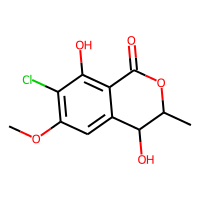

In [177]:
# Showing the query structure
draw_mol(query)

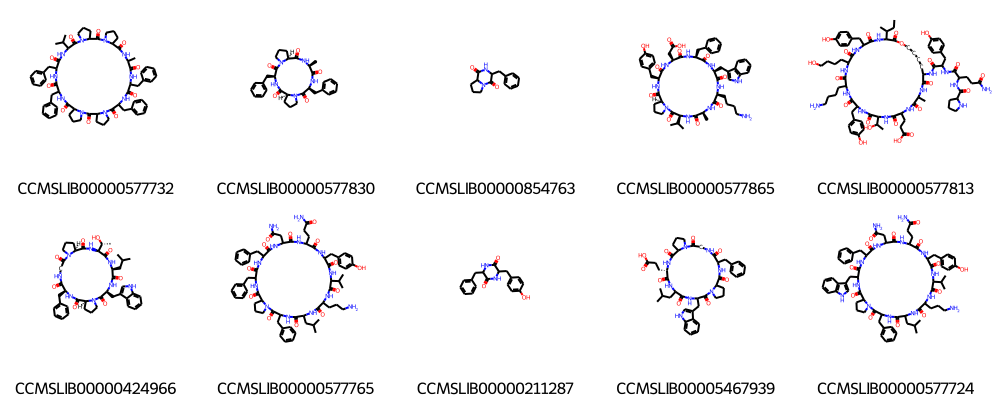

In [178]:
# Showing all nearest structures
draw_mols(nn_spec2vec_cca)